# Image Captioning using Flickr8k dataset

## Gaurav Singh 
## Hardik Kharpude

In this project we are going to generate captions from a bunch of images. For that purpose we are going to be using Flickr8k dataset from kaggle. We are going to pass the images through the VGG16 model to get the embeddings and then use another RNN model to get the captions after training. 
Dataset was taken from: https://www.kaggle.com/adityajn105/flickr8k/activity

In [20]:
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import add

Method to plot training and test loss

In [21]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

# Initial data loading and Exploration

In [22]:
images_path = "Pictures/archive/Images/"
captions_path= Path("captions.txt")

Creating image id for every image caption

In [23]:
lines = []
with open(captions_path) as f:
    lines = f.readlines()

image_id = []
image_caption = []
for line in lines:
    a,b = line.split(",",1)
    image_id.append(a)
    image_caption.append(b)

Sanity checking whether it's correct

In [24]:
listdir(images_path)[0]

'1000268201_693b08cb0e.jpg'

Now we are going to take just one caption for every image and eliminate the duplicates

In [25]:
df = pd.DataFrame({'id':image_id,'caption':image_caption})
df = df.drop_duplicates(subset = 'id')

In [26]:
image_id_unique = np.array(df['id'])
image_caption_unique = np.array(df['caption'])

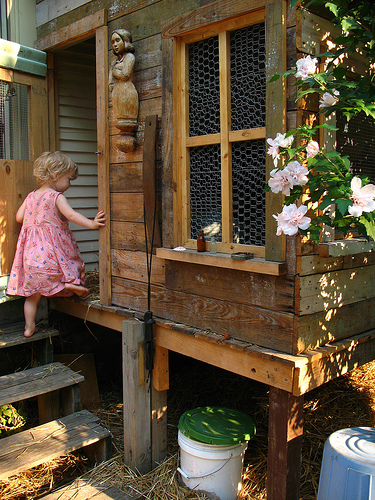

In [27]:
load_img(images_path  +image_id[0])

In [28]:
image_id[0]

'1000268201_693b08cb0e.jpg'

In [29]:
image_id[1]

'1000268201_693b08cb0e.jpg'

In [31]:
print(image_id[0] , " " , image_caption[0])

1000268201_693b08cb0e.jpg   A child in a pink dress is climbing up a set of stairs in an entry way .



We are going to use 7900 images for training and the remaining 121 for testing

In [32]:
image_id_train = image_id_unique[:7900]
image_caption_train = image_caption_unique[:7900]

In [33]:
image_id_test = image_id_unique[7900:]
image_caption_test = image_caption_unique[7900:]

# Loading the VGG16 model

Using the VGG16 model to get the embeddings of the images

In [34]:
# load the model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# Getting image embeddings using the VGG model

Preprocessing image and inputting it into the VGG model to get the embeddings

In [35]:
def create_image_features(directory,image_id):
  temp=[]
  for i in image_id:
    # load an image from file
    filename = i
    image = load_img(images_path + filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess input for the VGG model
    image = preprocess_input(image)
    # get embeddings
    temp.append(model.predict(image))
  return np.array(temp)

Getting the embeddings for our training and test images

In [36]:
images_train = create_image_features(images_path,image_id_train)

In [37]:
images_test = create_image_features(images_path,image_id_test)

In [38]:
listdir(images_path)[10]

'101654506_8eb26cfb60.jpg'

In [39]:
image_id_train[10]

'101654506_8eb26cfb60.jpg'

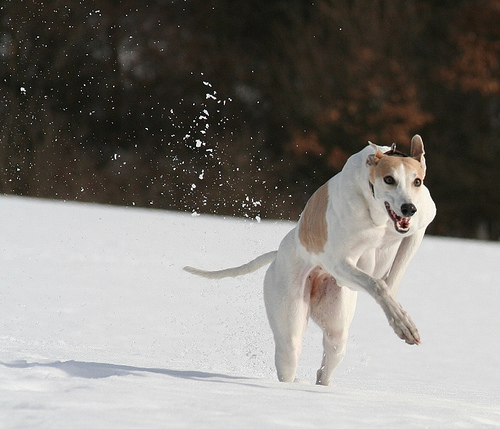

In [40]:
load_img(images_path  +image_id_train[10])

# Caption Cleaning and Mapping words to indexes

Now we are going to clean the captions by converting them to lower case, removing punctuations and removing numbers

In [41]:
import string
def clean_descriptions(desc_list):
    table = str.maketrans('', '', string.punctuation)
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split(' ')
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation
        desc = [w.translate(table) for w in desc]
        desc = [word for word in desc if len(word)>1]
        # remove numbers
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)
    return desc_list

image_caption_clean_train = clean_descriptions(image_caption_train)
image_caption_clean_test = clean_descriptions(image_caption_test)

In [42]:
image_caption_clean_train[10]

'brown and white dog is running through the snow'

In [43]:
image_caption_clean_test[10]

'boy and girl go down metal slide'

Putting startseq and endseq at the start and end of each caption. Start sequence will help the decoder in our model to tell when to start generating captions and stop sequence will tell it when to stop.

In [44]:
for i in range(len(image_caption_clean_train)):
    image_caption_clean_train[i] = 'startseq '+ ''.join(image_caption_clean_train[i]) + ' endseq'

In [45]:
for i in range(len(image_caption_clean_test)):
    image_caption_clean_test[i] = 'startseq '+ ''.join(image_caption_clean_test[i]) + ' endseq'

In [46]:
image_caption_clean_train[10]

'startseq brown and white dog is running through the snow endseq'

In [47]:
image_caption_clean_test[10]

'startseq boy and girl go down metal slide endseq'

Tokenizing the image captions. Assigning index to every unique word in our caption.

In [48]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [49]:
image_caption_train = image_caption_clean_train
image_caption_test = image_caption_clean_test

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(image_caption_train.tolist())

Getting the max length of any caption and the vocabulary size to input it in the model 

In [51]:
max_length = max(len(d.split()) for d in image_caption_train)
vocab_size = len(tokenizer.word_index) + 1

Creating sequences to input in the model. The entire caption is going to be divided into sequences. We are not going to be passing the entire sentence at once but instead pass it word by word. 
For example: Let's say we have a sentence - startseq the blue shirt endseq. 
Every word in the sentence now has a number assigned to it.
let's say startseq-0,the-5,blue-8,shirt-15, endseq-10
So we pass the data like - <br>Step 1: 0            topredict-5 <br>
                           <br>Step 2: 0,5          topredict - 8<br>
                           <br>Step 3: 0,5,8        topredict - 15<br>
                           <br>Step 4: 0,5,8,15     topredict - 10<br>

In [52]:
# https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size,imgArr_size):
    X1, X2, y = list(), list(), list()
    num = 0
    for desc in descriptions:
        # Convert to sequences
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # categorically encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photos[num])
            X2.append(in_seq)
            y.append(out_seq)
        if num<imgArr_size:
            num = num+1
    return np.array(X1), np.array(X2), np.array(y)

In [53]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, image_caption_train.tolist(), images_train, vocab_size,7999)


In [54]:
X1test, X2test, ytest = create_sequences(tokenizer, max_length, image_caption_test.tolist(), images_test, vocab_size,190)

In [55]:
ytrain.shape

(79916, 4373)

We are going to fit our data into this model and get the results. The model was taken from a different source and modified to be suitable for our data

In [56]:
def define_model(vocab_size, max_length):
    # Image extraction
    inputs1 = Input(shape=(4096))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # Generating captions in sequences
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = layers.LSTM(256)(se2)
    # Adding them both together in the decoder model and applying softmax
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    return model

In [57]:
X1train.shape

(79916, 1, 4096)

We have 4373 unique words in our training set

In [58]:
vocab_size

4373

In [59]:
model = define_model(vocab_size,max_length)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      1119488     input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_3[0][0]                    
_______________________________________________________________________________________

In [60]:
X1train.shape

(79916, 1, 4096)

In [61]:
X1test.shape

(1892, 1, 4096)

Reshaping data so that it can be put into the model

In [62]:
X1_train_reshaped = X1train.reshape((X1train.shape[0],4096))
X1_test_reshaped = X1test.reshape((X1test.shape[0],4096))

# Training the Model

In [63]:
history = model.fit([X1_train_reshaped, X2train], ytrain, epochs=5, validation_data=([X1_test_reshaped, X2test], ytest))

Epoch 1/5
2498/2498 [==============================] - 213s 85ms/step - loss: 4.9847 - val_loss: 4.3547
Epoch 2/5
2498/2498 [==============================] - 188s 75ms/step - loss: 4.1764 - val_loss: 4.0774
Epoch 3/5
2498/2498 [==============================] - 185s 74ms/step - loss: 3.8501 - val_loss: 4.0030
Epoch 4/5
2498/2498 [==============================] - 188s 75ms/step - loss: 3.6304 - val_loss: 3.9570
Epoch 5/5
2498/2498 [==============================] - 189s 76ms/step - loss: 3.4571 - val_loss: 3.9886


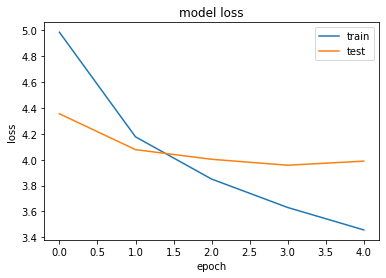

In [64]:
plot_metric(history)

We are going to run our model for only 5 epochs as it starts to overfit after that

# Testing the model

Now we are going to map the indexes back to words and predict our new caption sequence by sequence

In [65]:
# https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

Function to extract features from a single photo

In [66]:
def extract_features(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

Now let's look at a few of our test images and what captions our model generated for them

### Image 1

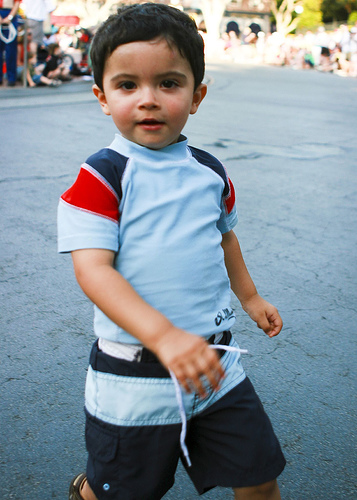

In [77]:
load_img(images_path + image_id_test[0])

In [78]:
generate_desc(model, tokenizer,images_test[0] , max_length) # Generated Caption

'startseq boy in blue shirt is standing on the street endseq'

In [151]:
image_caption_test[0] # Actual Caption

'startseq boy in blue shirt endseq'

The caption for the first image for almost perfect

### Image 2

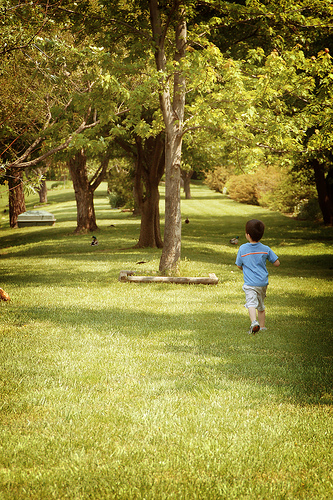

In [83]:
load_img(images_path + image_id_test[3])

In [84]:
generate_desc(model, tokenizer,images_test[3] , max_length) # Generated caption

'startseq boy in blue shirt is standing on the grass endseq'

In [152]:
image_caption_test[3] # Actual Caption

'startseq boy walks in meadow near some trees endseq'

The caption for the second image is also great

### Image 3

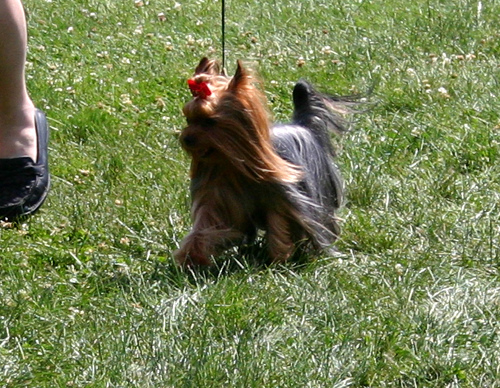

In [85]:
load_img(images_path + image_id_test[4])

In [86]:
generate_desc(model, tokenizer,images_test[4] , max_length)

'startseq black and white dog is running on the grass endseq'

In [153]:
image_caption_test[4] # Actual Caption

'startseq dog on the heels of man endseq'

The caption for the third picture misses by quite a bit calling the dog black and white

### Image 4

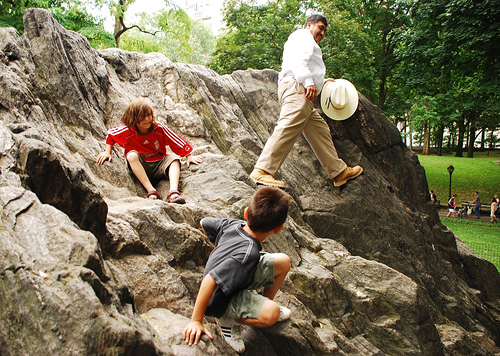

In [90]:
load_img(images_path + image_id_test[7])

In [91]:
generate_desc(model, tokenizer,images_test[7] , max_length) # Generated Caption

'startseq man in red shirt is riding skateboard on rock endseq'

In [154]:
image_caption_test[7] # Actual Caption

'startseq group of people walking on rocky ridge endseq'

This caption has got the spirit but it missed the mark!

### Image 5

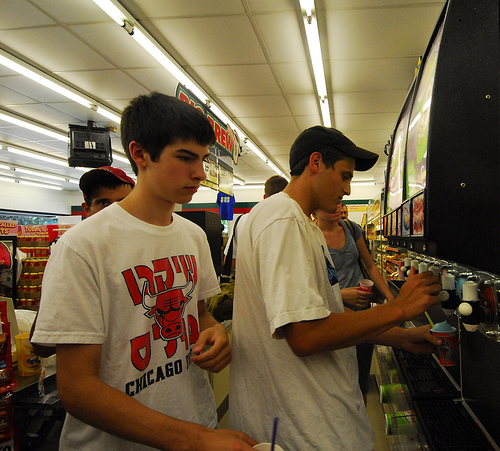

In [109]:
load_img(images_path + image_id_test[24])

In [110]:
generate_desc(model, tokenizer,images_test[24] , max_length) # Generated Caption

'startseq man in white shirt is standing in front of the camera endseq'

In [155]:
image_caption_test[24] # Actual Caption

'startseq group of people are getting fountain drinks at convenience store endseq'

The actual caption is quite complicated for our current model to generate but it still did a decent job with the image

### Image 6

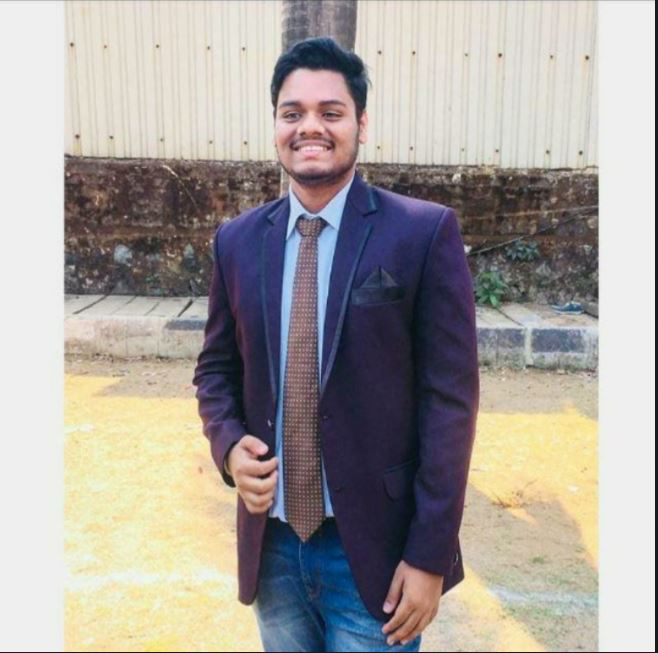

In [118]:
hardik = extract_features(images_path + 'hardik.jpg')
load_img(images_path + 'hardik.jpg')

In [119]:
generate_desc(model, tokenizer,hardik , max_length) # Generated Caption

'startseq man in black shirt is standing in front of the street endseq'

The model still did great on a random image

# Conclusion

Our model started to overfit after just the fifth epoch and the captions generated were nowhere near perfect. We need more than 8000 images if we want to build a good image captioning model. Also we need similar images for our test data like we had in our training data for our model to work better. The model won't work well on completely different images. We only used a single caption for all the 7900 images that we used for training. Using five captions for every image would have helped improve the vocabulary by adding more words for the model to learn for each image. Tokenizer only accepts lists and not numpy arrays and if you try to pass a numpy array to it you get empty sequence arrays which will have your model generate same caption for every image.